In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spikingDataUtilities import loadMATData, spikeTimes, firingRate, restrict

In [2]:
data_dir = '/Users/giacomopreti/Desktop/BH2026/raw'
data = loadMATData(f"{data_dir}/session1.mat")

In [3]:
data['protocol_names']

['sleep1', 'task1', 'sleep2', 'task2', 'sleep3']

In [4]:
data['ripples'] + [-0.5, 0.5]

array([[ 1455.2048,  1456.2048],
       [ 1460.24  ,  1461.24  ],
       [ 1467.1552,  1468.1552],
       ...,
       [27118.4944, 27119.4944],
       [27120.8768, 27121.8768],
       [27121.096 , 27122.096 ]], shape=(4940, 2))

In [5]:
stacked = []
for spike_tipe in ['spikes_hpc', 'spikes_nr', 'spikes_pfc']:
    sleep_data = restrict(data[spike_tipe], [data['protocol_times'][0]])
    sleep_firing_rate = firingRate(sleep_data, bin_size=1)
    sleep_firing_rate = np.delete(sleep_firing_rate, 0, axis=1) # Remove time zero column
    stacked.append(sleep_firing_rate)

stacked_firing_rates = np.hstack(stacked)

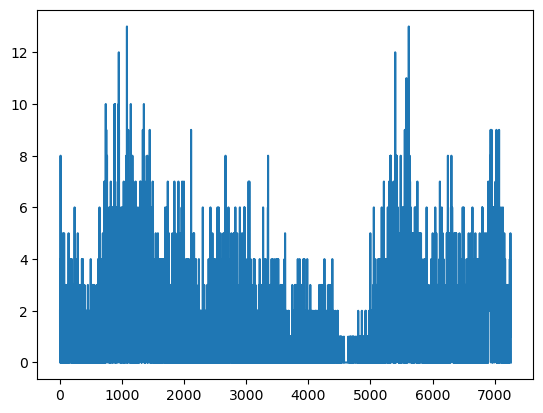

In [6]:
plt.plot(stacked_firing_rates[:,1])

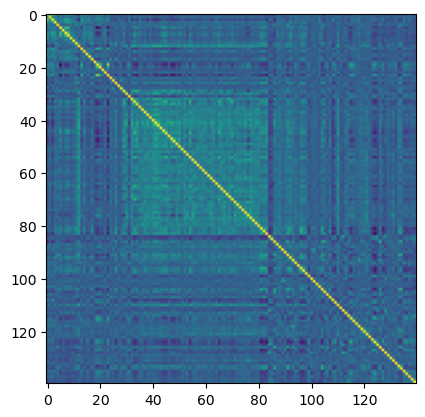

In [7]:
fc = np.corrcoef(stacked_firing_rates.T)
plt.imshow(fc)

In [8]:
stacked_firing_rates.shape

(7264, 140)

In [37]:
import importlib
import giaco_utils
importlib.reload(giaco_utils)
from giaco_utils import compute_fcd, compute_time_window_fc_t
fcd = compute_fcd(stacked_firing_rates, window_length=200, overlap=150)

/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/desuenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


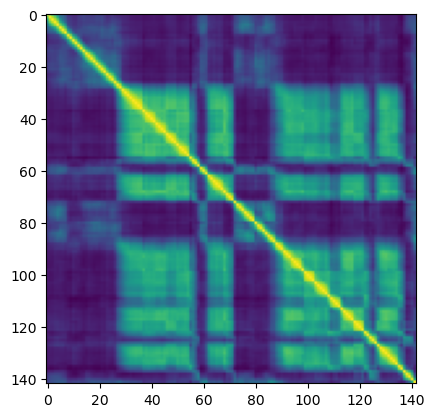

In [38]:
plt.imshow(fcd)

In [39]:
FC_t = compute_time_window_fc_t(stacked_firing_rates, window_length=200, overlap=150)

In [40]:
importlib.reload(giaco_utils)
from giaco_utils import silhouette_for_kmeans, run_kmeans

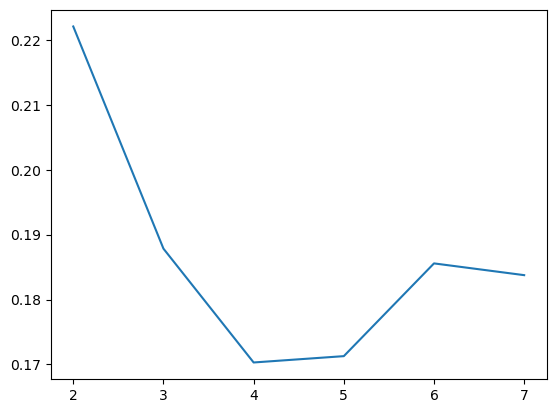

In [41]:
silhouette_for_kmeans(FC_t.T)

In [42]:
X_pca, labels = run_kmeans(FC_t.T, 5)

In [43]:
X_pca.shape

(142, 20)

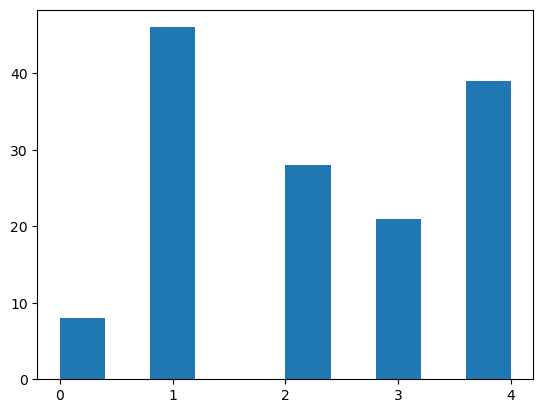

In [44]:
plt.hist(labels)
plt.xticks(range(5), range(5));

In [45]:
label_img = np.tile(labels[:, None], (1, len(labels)))
label_img.shape == (len(labels), len(labels))





True

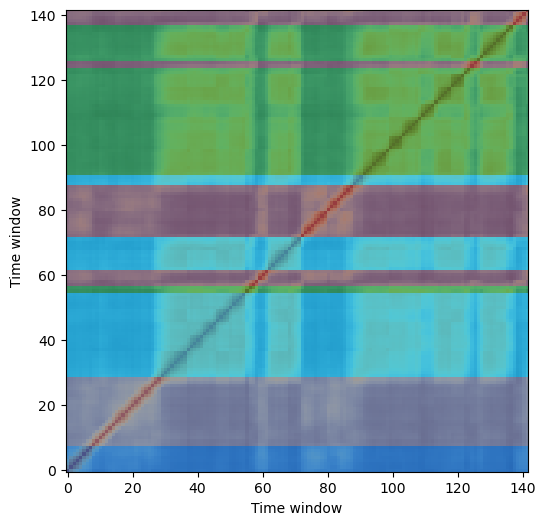

In [46]:
plt.figure(figsize=(6, 6))

# Base layer: FCD
plt.imshow(fcd, cmap="coolwarm", origin="lower")

# Overlay: labels
plt.imshow(label_img, cmap="tab10", origin="lower", alpha=0.7,
           interpolation="nearest")

plt.xlabel("Time window")
plt.ylabel("Time window")
plt.show()


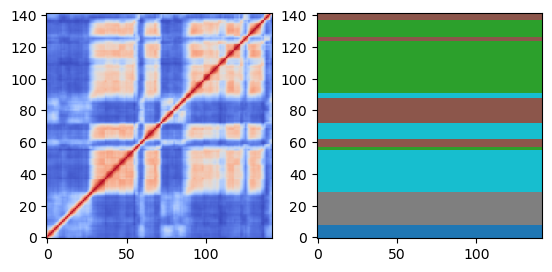

In [47]:
# Base layer: FCD
plt.subplot(121)
plt.imshow(fcd, cmap="coolwarm", origin="lower")
plt.subplot(122)
# Overlay: labels
plt.imshow(label_img, cmap="tab10", origin="lower", alpha=1,
           interpolation="nearest")

In [51]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

In [63]:
np.where(labels == 4)

(array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 88, 89, 90]),)

In [68]:
n = 140
vec = FC_t[:, 90]
FC = np.zeros((n, n))

# Upper triangle indices (excluding diagonal)
iu = np.triu_indices(n, k=1)

# Fill upper triangle
FC[iu] = vec

# Mirror to lower triangle
FC = FC + FC.T

# Optional: set diagonal
np.fill_diagonal(FC, 1.0)



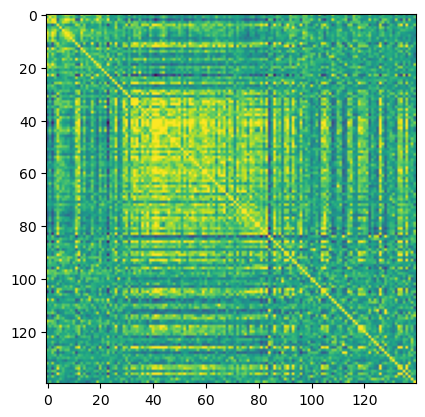

In [69]:
plt.imshow(FC, vmax=0.4)

In [375]:
spikes_hpc = spikeTimes(data['spikes_hpc'], data['protocol_times'])
spikes_nr = spikeTimes(data['spikes_nr'], data['protocol_times'])
spikes_pfc = spikeTimes(data['spikes_pfc'], data['protocol_times'])

In [378]:
spike_times = spikes_hpc[1]

In [383]:
spike_times = [np.asarray(s, dtype=float) for s in spike_times]

In [407]:
importlib.reload(giaco_utils)
from giaco_utils import get_sttc_matrix, sttc

delta_t = 0.02   # 10 ms
T = 10000

STTC = get_sttc_matrix(spike_times,delta_t, T)


In [434]:
np.max(spike_times[0])

np.float64(10000.3869)

In [435]:
from joblib import Parallel, delayed

def spikes_in_window(spike_times, start, end):
    """
    Get spike times of each neuron within [start, end)
    """
    return [s[(s >= start) & (s < end)] - start for s in spike_times]

def dynamic_sttc(spike_times, delta_t, T, window_length, step_size, n_jobs=8):
    """
    Compute time-resolved STTC matrix for all sliding windows.
    
    Returns:
        sttc_dyn: np.array, shape (n_windows, n_neurons, n_neurons)
        window_starts: list of window start times
    """
    n_neurons = len(spike_times)
    window_starts = np.arange(np.min(spike_times[0]), T - window_length + 1, step_size)
    n_windows = len(window_starts)
    
    sttc_dyn = np.zeros((n_windows, n_neurons, n_neurons))
    
    for w, start in enumerate(window_starts):
        end = start + window_length
        window_spikes = spikes_in_window(spike_times, start, end)
        
        # Compute STTC for this window
        pairs = [(i, j) for i in range(n_neurons) for j in range(i+1, n_neurons)]
        results = Parallel(n_jobs=n_jobs)(
            delayed(sttc)(window_spikes[i], window_spikes[j], delta_t, window_length)
            for i, j in pairs
        )
        
        # Fill symmetric matrix
        k = 0
        for i in range(n_neurons):
            for j in range(i+1, n_neurons):
                sttc_dyn[w, i, j] = results[k]
                sttc_dyn[w, j, i] = results[k]
                k += 1
                
    return sttc_dyn, window_starts



In [411]:
len(spike_times[1])

1725

In [520]:
sttc_dyn, _ = dynamic_sttc(spike_times, 0.1, 10000, 100, 15)

In [521]:
corr = []
for matri in sttc_dyn:
    for x in sttc_dyn:
        corr.append(np.corrcoef(matri.flatten(), x.flatten())[0][1])

corr = np.array(corr).reshape(len(sttc_dyn), len(sttc_dyn))

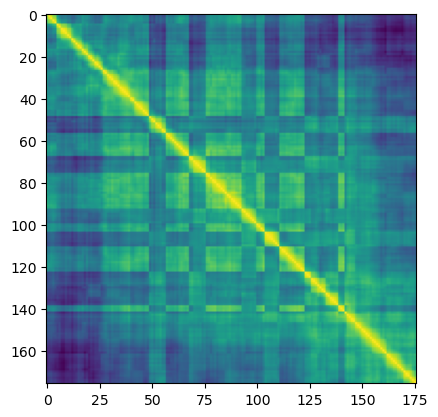

In [522]:
plt.imshow(corr)

In [523]:
fcd_metr = []

for i in range(sttc_dyn.shape[0]):
    FC = sttc_dyn[i]                # shape (n_neurons, n_neurons)
    Isupdiag = np.triu_indices(FC.shape[0], k=1)  # k=1 skips the diagonal
    fcd_metr.append(FC[Isupdiag])

fcd_metr = np.array(fcd_metr)       # shape (n_windows, n_edges)


In [524]:
fcd_metr.shape

(176, 406)

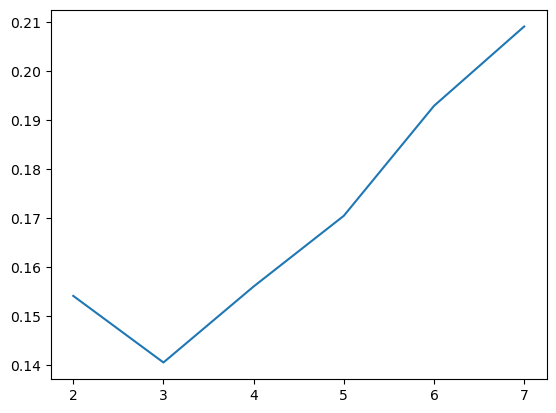

In [525]:
silhouette_for_kmeans(fcd_metr)

In [526]:
X_pca, labels = run_kmeans(fcd_metr, 6)

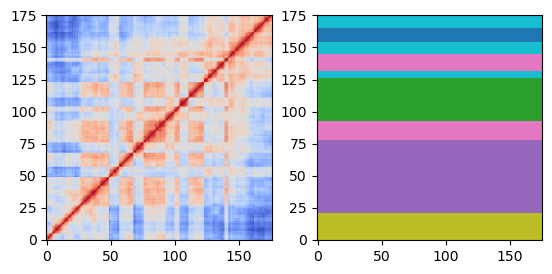

In [527]:
label_img = np.tile(labels[:, None], (1, len(labels)))
label_img.shape == (len(labels), len(labels))


# Base layer: FCD
plt.subplot(121)
plt.imshow(corr, cmap="coolwarm", origin="lower")
plt.subplot(122)
# Overlay: labels
plt.imshow(label_img, cmap="tab10", origin="lower", alpha=1,
           interpolation="nearest")